In [1]:
using DataFrames
using CSV
using Plots
using Distributions
using Arrow

In [2]:
include("shared/CommonFunctions.jl")
include("shared/CommonConstants.jl")
using .CommonFunctions
using .CommonConstants

Load up the betas data.

In [3]:
options_folder = option_foldername(; DEFAULT_OPTIONS...)

"local-rets_eq-strict"

In [4]:
model_outputs = Dict()
for (currency_risk, benchmark) in COMPLETE_MODELS
    model_filename = joinpath("..", DIRS.fund, "post-processing", options_folder, "factor-betas/$(benchmark)_$currency_risk.arrow")
    model_outputs[(currency_risk, benchmark)] = DataFrame(Arrow.Table(model_filename))
end

Extract the info required to calculate p-values and calculate all p-values.

In [5]:
function compute_pvalues(regression_data)
    regression_data.t = regression_data.coef ./ regression_data.se
    calc_p(row) = ccdf(FDist(1,row.df), row.t^2)
    p = calc_p.(eachrow(regression_data))
    
    return p
end

compute_pvalues (generic function with 1 method)

This function computes the proportions of significant p-values by date.

In [6]:
truth_fraction(bool_array) = count(==(true), bool_array)/length(bool_array)

truth_fraction (generic function with 1 method)

In [7]:
function proportion_sig(regression_data, model, sig_level, factor)
    if factor ∉ [:slope, :level, :either, :both]
        error("factor must be one of :slope, :level, :either, :both")
    end
    
    if factor == :slope
        factorset = [CURRENCYRISK_MODELS[model[1]][1]]
    elseif factor == :level
        factorset = [CURRENCYRISK_MODELS[model[1]][2]]
    else
        factorset = CURRENCYRISK_MODELS[model[1]]
    end
    
    if factor == :either
        checkeach = any
    else factor
        checkeach = all
    end

    currency_risk_only = regression_data[regression_data.factor .∈ Ref(factorset), :]
    obs_groups = groupby(currency_risk_only, [:fundid, :date])
    
    sig_table = combine(obs_groups, :pvalue => (pp->checkeach(pp .<= sig_level)) => :currency_sig)
    
    date_groups = groupby(sig_table, :date)
    sig_proportions = combine(date_groups, :currency_sig => truth_fraction => :proportion_sig)
    
    return sig_proportions
end

proportion_sig (generic function with 1 method)

This function can be called on a model name to compute the p-values, compute proportions of significant p-values by date, altogether

In [8]:
function build_proportion_sig_data(regression_data, model, sig_level, factor)
    regression_data.pvalue = compute_pvalues(regression_data)
    
    output = proportion_sig(regression_data, model, sig_level, factor)
    sort!(output, :date)
    
    return output
end 

build_proportion_sig_data (generic function with 1 method)

This function plots a time series of proportion values.

In [9]:
function draw_proportion_plot(proportion_table, model_name)
    x = proportion_table.date
    y = proportion_table.proportion_sig
    p = plot(x, y, title=model_name, legend=false)
    plot!(xlabel="Date", xguidefontsize=10)
    plot!(ylabel="Proportion of Funds with \nSignificant Currency Exposure", yguidefontsize=10)
    display(p)
end

draw_proportion_plot (generic function with 1 method)

This function creates a plot from a model name and data source only.

In [10]:
function plot_currency_significance(data_source, model, factor=:both; datafilter=nothing)
    benchmark_model_name = replace(string(model[2]), "_"=>" ") |> uppercase
    currency_risk_model_name = uppercase(string(model[1]))
    plot_type = uppercase(string(factor))
    plot_title = "$benchmark_model_name + $currency_risk_model_name ($plot_type)"
    
    if isnothing(datafilter)
        data = data_source[model]
    else
        data = infofilter(datafilter, data_source[model], notebook=true)
        println("Filtered data to $(length(unique(data.fundid))) funds")
    end

    proportion_table = build_proportion_sig_data(data, model, 0.05, factor)
    
    draw_proportion_plot(proportion_table, plot_title)
end

plot_currency_significance (generic function with 2 methods)

In [11]:
function allplots(data_source, model; datafilter=nothing)
    for type in [:slope, :level, :either, :both]
        plot_currency_significance(data_source, model, type, datafilter=datafilter)
    end
end

allplots (generic function with 1 method)

Filtered data to 4346 funds


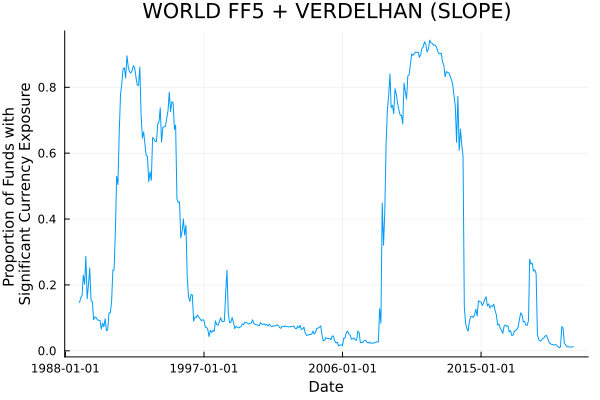

Filtered data to 4346 funds


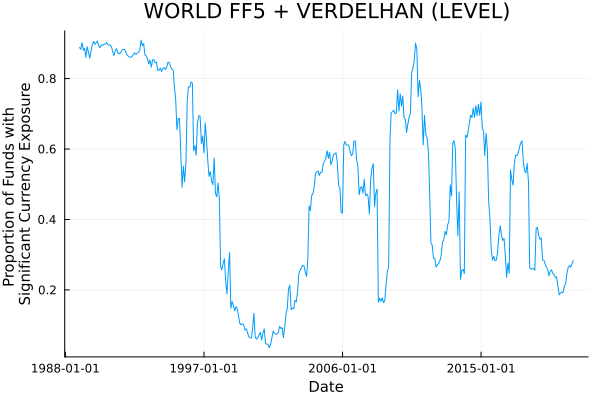

Filtered data to 4346 funds

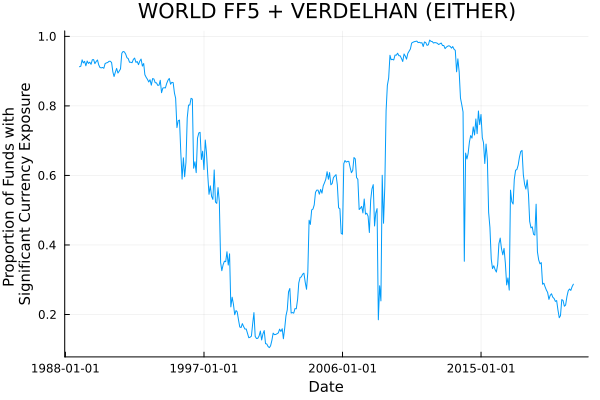

Filtered data to 4346 funds

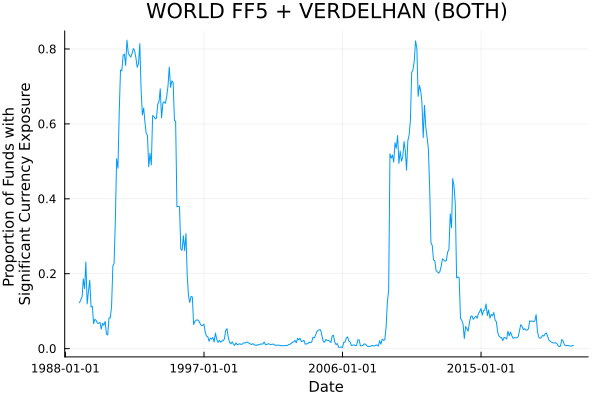

In [12]:
allplots(model_outputs, (:verdelhan, :world_ff5); datafilter=([:broad_category, :domicile, :passive]=>(x,y,z)->(nonmissing(x=="Equity") && nonmissing(y=="USA") && (ismissing(z) || !z))))

Filtered data to 4376 funds

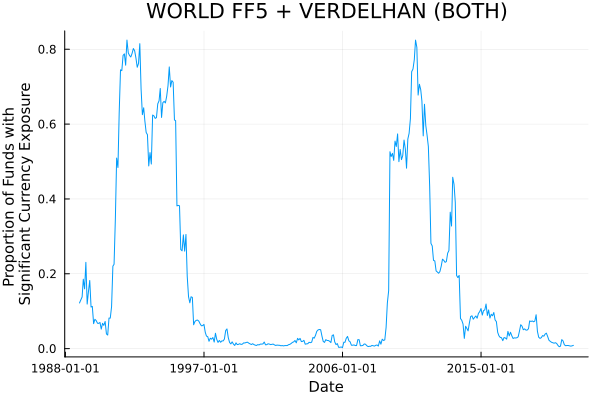

In [14]:
plot_currency_significance(model_outputs, (:verdelhan, :world_ff5), :both; datafilter=([:broad_category, :domicile]=>(x,y)->(nonmissing(x=="Equity") && nonmissing(y=="USA"))))

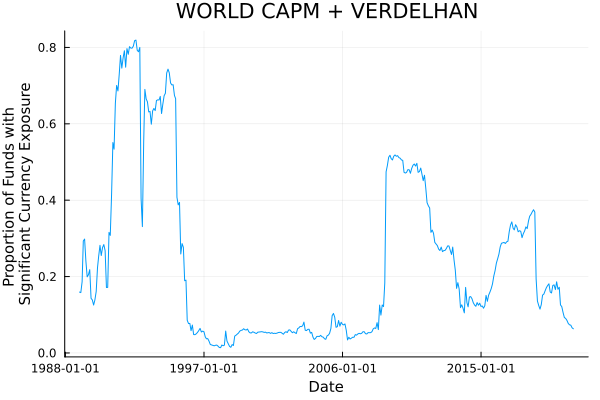

In [11]:
plot_currency_significance(model_outputs, (:verdelhan, :world_capm), "both")

In [19]:
for i in COMPLETE_MODELS
    plot_currency_significance(model_outputs, i, "level")
    plot_currency_significance(model_outputs, i, "slope")
    plot_currency_significance(model_outputs, i, "either")
    plot_currency_significance(model_outputs, i, "both")
end